# Task 3 - Model Explainability
1. Feature Importance Baseline
2. SHAP Analysis
3. Interpretation
4. Business Recommendations

## Import Libary

In [1]:
import joblib
import pandas as pd
import numpy as np
import sys 
sys.path.append('..')
from src.load import load_data
from src.shap import ShapExplainer
from src.ploter import Ploter
ploter = Ploter()

## Load Model, X_train and X_test

In [2]:
# Load data
X_train = np.load('../Data/processed/X_fraud_train.npy', allow_pickle=True)
X_test = np.load('../Data/processed/X_fraud_test.npy', allow_pickle=True)
y_test = np.load('../Data/processed/y_fraud_test.npy', allow_pickle=True)
# load Manually create feature names
path = ('../Data/processed/feature_names_fraud.csv')
feature_names_df = load_data(path)
feature_names = feature_names_df.iloc[:, 1].tolist() # Take the second column
# Load trained model
best_rf = joblib.load("../models/fraud_model.joblib")
# Convert NumPy arrays to DataFrames for SHAP
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test  = pd.DataFrame(X_test, columns=feature_names)
# Check
print(X_train.columns[:10])

Index(['purchase_value', 'age', 'hour_of_purchase', 'day_of_purchase',
       'time_since_signup', 'transaction_count', 'browser_FireFox',
       'browser_IE', 'browser_Opera', 'browser_Safari'],
      dtype='object')


## Built-in Feature Importance (Baseline)

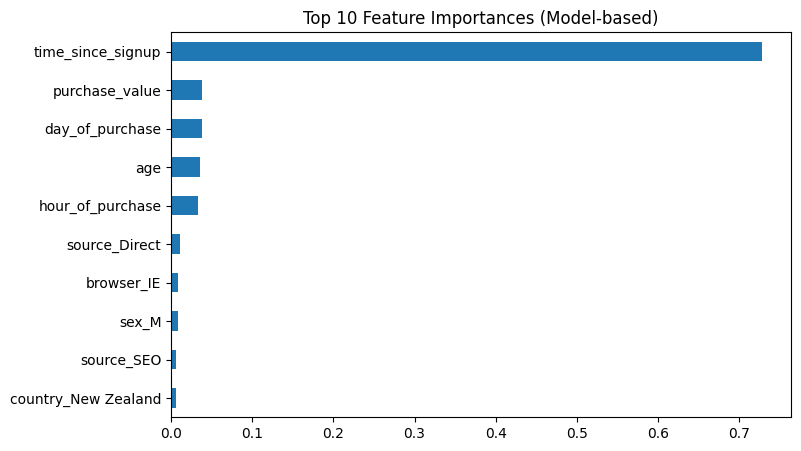

In [3]:
importances = best_rf.feature_importances_

feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
ploter.bar_feature_importance(feature_importances.head(10))

### Key Takeaways from Data
Dominant Predictor: time_since_signup is by far the most important feature. With a score above 0.7, it carries more weight than all other features combined. This suggests that the timing of a user's action relative to when they joined is the strongest signal for the model is trying to predict (fraud detection).

## SHAP Analysis

In [3]:
shap_explainer = ShapExplainer(model=best_rf, x_train=X_train, x_test=X_test)

## Generate SHAP Summary Plot (global feature importance)

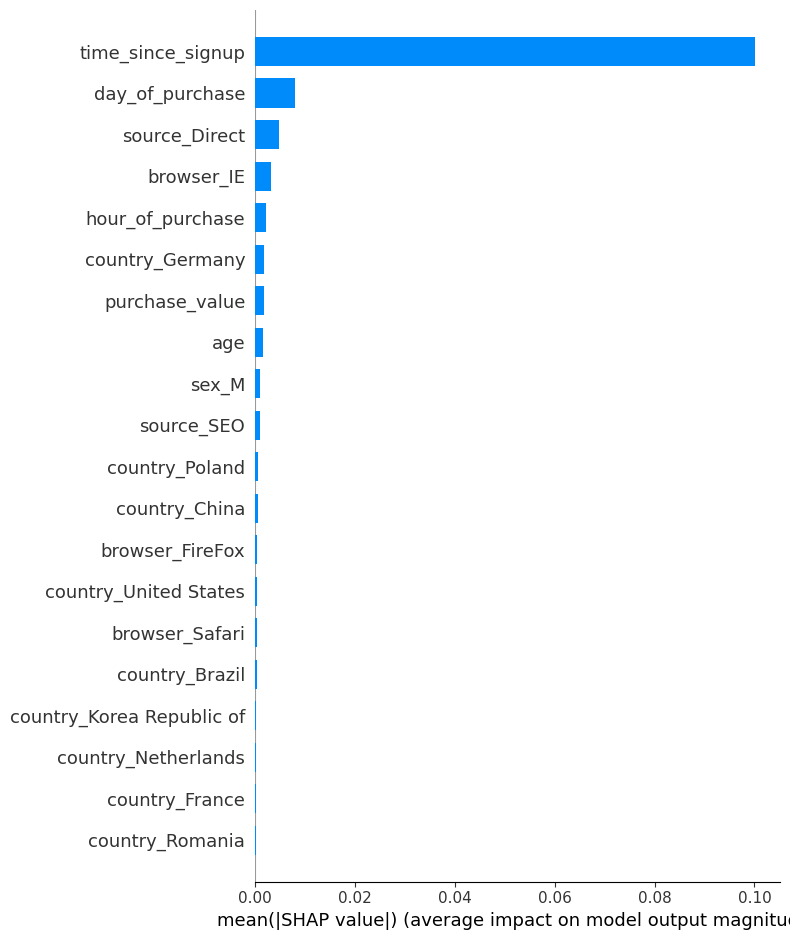

In [5]:
shap_explainer.plot_shap_summary()

## SHAP Force Plots (Local Explanations)

In [4]:
y_pred = best_rf.predict(X_test)
# True Positive (Fraud correctly detected)
tp_idx = np.where((y_test==1) & (y_pred==1))[0][0]

# False Positive (Fraud correctly detected)
fp_idx = np.where((y_test==0)&(y_pred==1))[0][0]

# False Negative (Fraud correctly detected)
fn_idx = np.where((y_test==1)&(y_pred==0))[0][0]

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


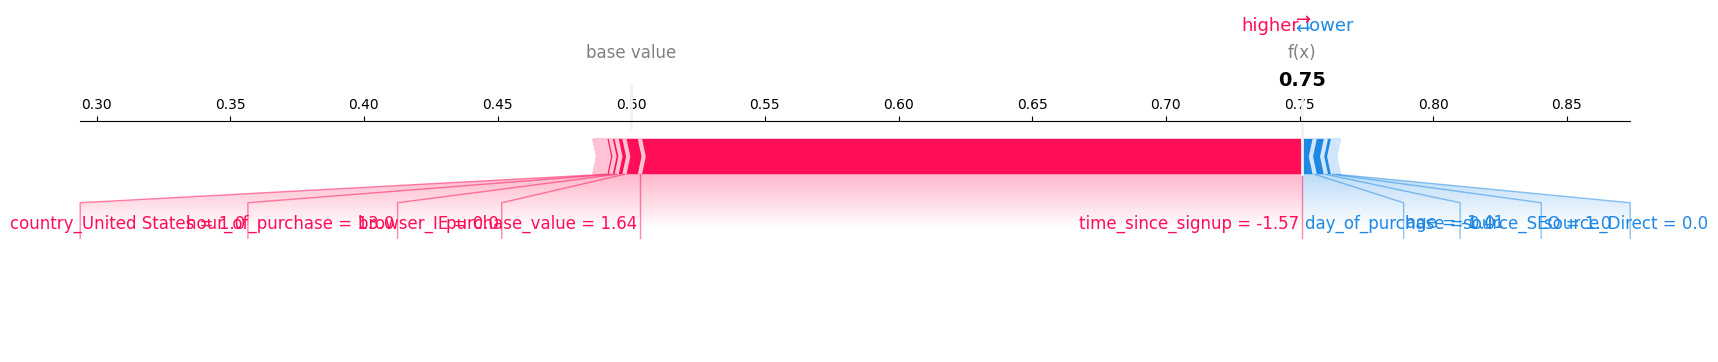

In [5]:
shap_explainer.plot_force(tp_idx)

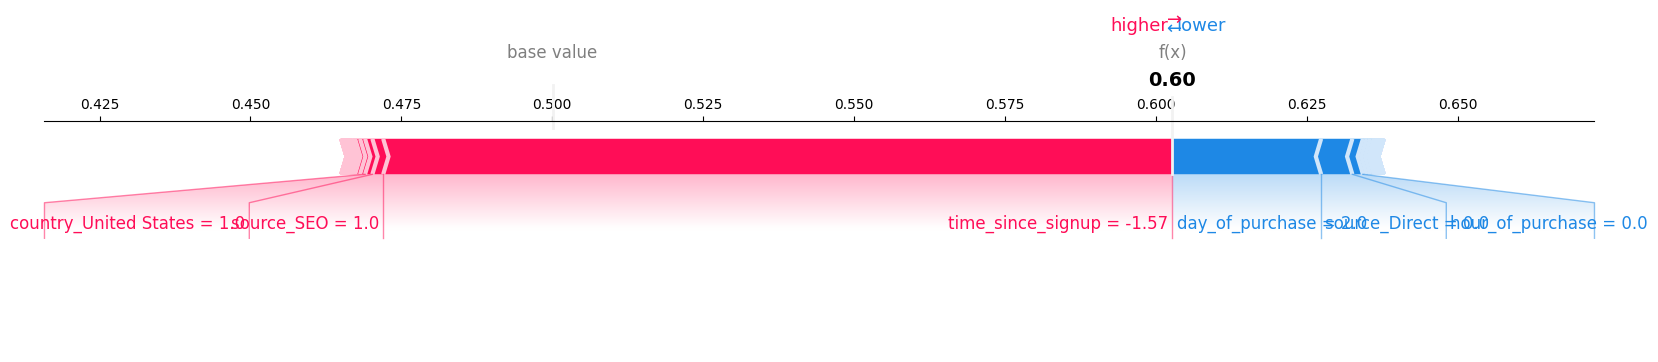

In [6]:
shap_explainer.plot_force(fp_idx)

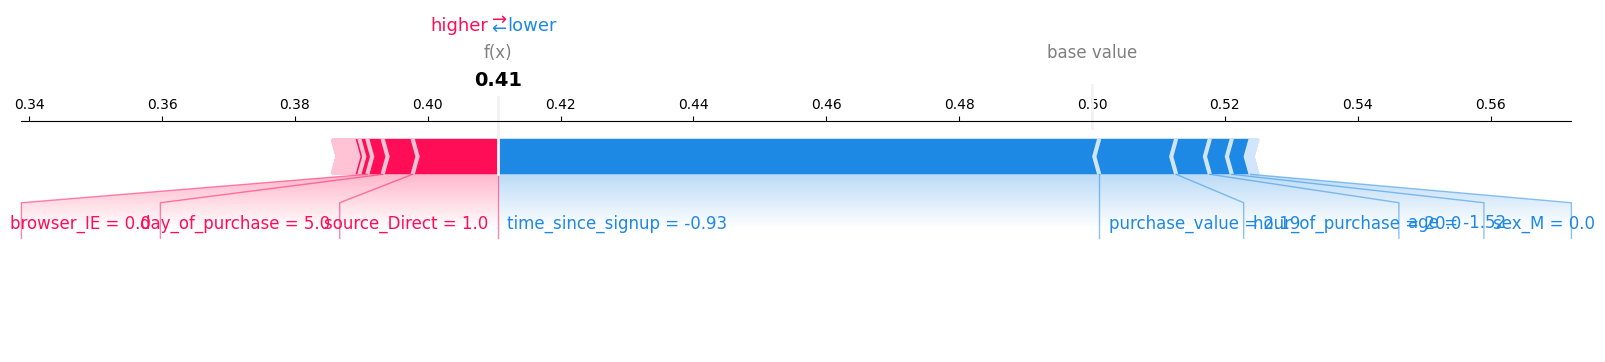

In [7]:
shap_explainer.plot_force(fn_idx)

# Interpretation
## Compare SHAP importance with built-in feature importance
### Built-in (Random Forest) feature importance:
1. Top feature:time_since_signup(~0.7)
2. Other features (purchase_value, day_of_purchase, age , hour_of_purchase) have much smaller contributions.
3. Categorical features(browser, country, source) contribute very little.
### SHAP global importance:
1. Confirms time_since_signup as the most important feature
2. Shows other impactful features: day_of_purchase, source_Direct, browser_IE, hour_of_purchase
3. Captures both continuous and categorical contributions, giving a more nuanced view
## Top 5 drivers of fraud predictions (from SHAP)
1. Time since signup – shorter time strongly increases fraud probability
2. Day of purchase – certain days slightly increase risk
3. Source (Direct traffic) – directs tend to have higher fraud risk
4. Browser (IE) – older or less common browsers show slightly higher fraud risk
5. Hour of purchase – unusual purchase times can indicate fraud
These drivers combine user behavior, transaction timing, and platform/device signals.
## Surprising or counterintuitive findings
purchase_value is less important than expected: High-value purchases are not the main driver; rapid early transactions matter more.

Country influence is minimal in global SHAP: Some countries have risk, but globally they are minor compared to behavioral features.

Browser type matters subtly: Some rare browsers contribute to fraud probability; this may reflect outdated software or bot behavior, which is less intuitive at first glance.

SHAP gives richer insight than plain feature importance.
Behavioral features dominate fraud detection, more than transaction amount or location.
Understanding these drivers helps design better verification rules and reduce false positives while catching true fraud.

# Business Recommendations
## 1. Verify transactions made shortly after signup

Recommendation: Transactions occurring within the first few hours of account creation should trigger additional verification (e.g., OTP or manual review).

SHAP Insight: time_since_signup is the dominant driver of fraud, with lower values strongly increasing fraud probability. True positive force plots confirm early-signup transactions are high-risk.

Business Impact: Prevents rapid-signup fraud without blocking legitimate long-standing users.
## 2. Monitor high-risk traffic sources and browsers
Recommendation: Transactions from Direct traffic sources or uncommon browsers (like IE) should have stricter fraud monitoring.

SHAP Insight: source_Direct and browser_IE contribute positively to predicted fraud probability in SHAP summary plots.False positives and true positives often involve these features.

Business Impact: Targets potential bot or scripted transactions while minimizing customer friction for safe sources.
## 3. Flag unusual transaction timing patterns
Recommendation: Purchases made at unusual hours or on specific high-risk days should be flagged for verification or risk scoring.

SHAP Insight: hour_of_purchase and day_of_purchase appear in the SHAP summary as moderate contributors, indicating timing affects fraud predictions. Force plots for false negatives highlight these as missed indicators.

Business Impact: Detects fraud attempts that mimic normal patterns in amount or location but happen at abnormal times, improving overall detection accuracy.